In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import json
from fbprophet.serialize import model_to_json, model_from_json
import warnings
warnings.filterwarnings('ignore')

- the outliers in data are removed before by analyzing std and mean of a particular window.
- Now,to remove sudden increase in prices we smoothened the curve by taking moving average.
- We split the data into traning data(total_length-14) + validation_data(7days) + test_data(7 days)

In [37]:
#data Processing
VEGETABLE= 'onion'
df = pd.read_csv("./data/"+VEGETABLE+'_NO_OUTLIERS.csv')
df = df.drop(['Unnamed: 0'], axis= 1)
df['DATE'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df['MODAL'] = df['MODAL'].apply(lambda x: float(x))
df = df.set_index('DATE')
df = df.rolling(7).mean()
df = df.reset_index()
df.columns = ['ds','y']
df = df.sort_values(by=['ds'])
train_data = df[:-609] #2010-2018
validation_data = df[-609:-244] #2019
test_data = df[-244:] #2020
train_validation_df = pd.concat([train_data, validation_data])


In [38]:
#model
# m = Prophet()
# m.fit(train_data)
# future = m.make_future_dataframe(periods=609)
# forecast = m.predict(future)


m = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=0.01,
                yearly_seasonality=10,
                seasonality_mode='multiplicative')
m.fit(train_data)
future = m.make_future_dataframe(periods=609)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- modification of forecast values predicted by prophet by checking the error produced in previous week

In [ ]:
#validation
def validate(C1, C2, C, D, forecast, df):
    f2 = forecast.copy()
    f2['orj'] = pd.Series(df['y'].to_numpy())
    for i in range(1, (len(forecast)//7)-1):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7, (i)*7):
            if abs(forecast['yhat_lower'][j]-forecast['yhat_upper'][j])*C1 < abs(forecast['yhat'][j]-df['y'][j]):
                cnt += 1
            if forecast['yhat'][j]-df['y'][j] < 0:
                upp += 1
            else: low += 1
        if cnt >= C2:
            for j in range((i)*7, (i+1)*7):
                print(forecast['yhat'][j], f2['yhat'][j-7], df['y'][j-7], forecast['yhat_upper'][j],df['y'][j],forecast['yhat_upper'][j-7])
                f2['yhat'][j] = C[0] * forecast['yhat'][j] + C[1] * f2['yhat'][j-7] + C[2] * (df['y'][j-7])
                if upp > low:
                    f2['yhat'][j] += D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]
                else:
                    f2['yhat'][j] += D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]
    f2['sqe'] = (f2['yhat'] - f2['orj'])**2
    return f2

def calc_train_remse(f2):
    return (f2['sqe'][:-609].sum()/(len(f2['sqe'])-609))**(1/2)
def calc_validation_rmse(f2):
    return (f2['sqe'][-609:-244].sum()/365)**(1/2)
def cal_test_rmse(f2):
    return (f2['sqe'][-244:].sum()/244)**(1/2)

X1 = np.linspace(0.1, 1, num=10)
X2 = np.linspace(0.1, 1, num=10)
X3 = np.linspace(0.1, 1, num=10)
D1 = [0.1,0.2,0.3]
D2 = [0.1,0.2,0.3]
counter = 0
validation_rmses = []
forecasts = []
for d1 in D1:
    for d2 in D2:    
        for x1 in X1:
            for x2 in X2:
                for x3 in X3:
                        if x1+x2+x3+d1+d2!=1:
                            continue
                        forecasts.append(validate(0.12,3,[x1,x2,x3],[d1,d2], forecast, df))
                        validation_rmses.append(([x1,x2,x3],[d1,d2],calc_validation_rmse(forecasts[-1])))
                        
                        
validation_rmses.sort(key= lambda x: x[2])
validation_rmses[:10]


964.115427207953 962.1866900358013 1175.0 1710.917954681378 1163.474025974026 1666.7397836889265
962.8794949407832 963.3422838148895 1159.5238095238094 1661.654678682733 1168.2359307359307 1647.2071531217648
961.2919358210627 964.2024250205137 1141.0714285714287 1670.3625803420905 1179.5454545454545 1673.4224831332253
959.3701652409229 964.7498513370099 1137.5 1685.4772573215218 1197.4025974025974 1665.0536385712264
957.6837690100099 965.516383811913 1145.6168831168832 1707.4842056852062 1214.2857142857142 1741.819107844981
955.1429877529077 965.3823539026814 1154.5454545454545 1667.5606217256714 1239.2857142857142 1713.2383110922385
952.4198526874849 964.9827005754511 1159.9025974025974 1693.3215862253878 1276.7857142857142 1705.8102030131029
949.3438797858192 1235.3959855614057 1163.474025974026 1727.6289823678376 1294.642857142857 1710.917954681378
946.0445177967272 1219.2226467703026 1168.2359307359307 1715.6069572153115 1313.6904761904764 1661.654678682733
942.5658177513583 1211.5

1119.8949371107483 1929.5120475725876 1803.5714285714275 1836.6923406592434 1767.8571428571418 1936.2669237319474
1116.5293951461335 1906.8812092435098 1749.9999999999989 1854.2531613323376 1874.9999999999989 1869.5914488125543
1113.002587995592 1896.0482086595366 1696.4285714285704 1792.4102599158764 1964.2857142857133 1875.5670604910576
1110.055484371535 1880.6393469741897 1660.7142857142846 1838.2835718865238 2053.5714285714275 1834.5896404246096
1107.435396494909 1861.5798949122166 1642.8571428571418 1834.8503573539667 2079.315476190475 1873.3847148762115
1105.2371456332469 1831.1386284473974 1672.6190476190463 1834.0533847777829 2095.684523809523 1863.7935005096354
1103.4522365963896 1791.9188804764822 1714.2857142857133 1926.2240084425885 2104.6130952380945 1800.2012722830032
1102.065826633138 1764.3794820503092 1767.8571428571418 1845.2896470604596 2109.0773809523803 1836.6923406592434
1101.7007225192217 1724.725521453453 1874.9999999999989 1818.3487490296661 2234.0773809523803 

1291.2035832313104 1280.9537168898787 1010.7142857142846 2009.978905255656 1112.4999999999989 2076.018027179742
1293.9198397104467 1282.644825213221 1017.8571428571419 2073.052949461737 1116.0714285714275 2009.506288773679
1295.7499892298388 1283.6488155475374 1029.1666666666656 2000.914279290016 1119.047619047618 1970.5525137082984
1297.7222225399976 1284.9985194871435 1044.6428571428562 2004.4998210243048 1121.4285714285702 2010.9056518483017
1299.466734181392 1004.5068001758525 1060.7142857142846 2005.3093537378463 1119.6428571428562 1990.1021143674777
1301.1069279147462 992.7288490180963 1077.3809523809512 2023.1887491789505 1117.2619047619037 2018.420271738795
1302.6232703465955 978.1659269542666 1094.6428571428562 2034.5095372762848 1114.285714285713 1992.6280983138688
1303.9914746152988 979.5697970264622 1112.4999999999989 2038.602342277426 1110.7142857142846 2009.978905255656
1306.1149275081186 986.0900519025029 1116.0714285714275 2030.9280373600236 1107.1428571428562 2073.0529

1595.343503319314 912.4395346906756 760.7142857142878 2343.736901820917 846.4285714285735 2332.5796536986827
1586.9925533109988 905.8046040100072 771.4285714285735 2305.293443627089 850.000000000002 2364.1919939748695
1577.7393083037923 891.2797465031301 785.7142857142878 2293.752991585694 851.7857142857164 2375.9314831625975
1568.8791406573166 881.8892675946067 800.000000000002 2299.7854503306658 855.3571428571449 2385.6718429403154
1560.0513902519247 879.865272895481 814.2857142857164 2300.2112079390686 855.3571428571449 2356.3753894463366
1551.4688046461672 881.7704900983799 828.5714285714306 2278.8022485121164 855.3571428571449 2337.980267590483
1543.1680339156414 892.6192913699848 839.2857142857164 2208.3796358903423 858.9285714285735 2320.961252274484
1535.1703743485891 887.032599717279 846.4285714285735 2226.376818663825 866.0714285714306 2343.736901820917
1528.5422020072112 896.578641437965 850.000000000002 2294.1322770204224 873.2142857142878 2305.293443627089
1521.14269381158

1959.0976450948103 1511.4118879861767 1606.2500000000025 2621.138980472345 1625.0000000000025 2652.4401241578103
1955.6028167795178 1520.6677526403803 1611.6071428571454 2670.1400487435844 1625.0000000000025 2645.0335485988644
1949.5711983247395 1529.8840688685314 1616.0714285714312 2670.232815677016 1625.0000000000025 2698.2640137848107
1942.1497566377016 1533.6271887496862 1619.6428571428598 2659.589168860126 1614.285714285717 2714.224701375164
1933.1194531561296 1529.6000650428814 1622.3214285714312 2661.095120771805 1603.5714285714312 2624.0461134484162
1922.7604188399216 1542.4696317398152 1624.1071428571454 2685.7257378748345 1599.7767857142883 2730.51414395115
1911.220996714305 1543.201567507651 1625.0000000000025 2629.6419024404263 1595.6349206349234 2700.8158690255823
1898.6505468821842 1557.2393670694273 1625.0000000000025 2647.3454540452785 1590.7614087301615 2621.138980472345
1886.1043142085148 1559.4128810710304 1625.0000000000025 2632.6813560569444 1584.7718253968285 2670

2510.76944356891 2353.642823715632 2910.3136446886465 3225.674119286133 3321.4285714285734 3145.364448144845
2532.706218720575 2375.5712239540344 3116.0714285714307 3253.8645810198 3321.4285714285734 3113.8044466214856
2554.5622253441406 2397.95805587311 3160.7142857142876 3247.3481602634174 3321.4285714285734 3118.7255805401924
2575.799385482735 2615.516840395135 3214.2857142857165 3283.528223288131 3336.3095238095257 3138.272582752732
2596.586853579799 2666.496600494931 3250.0000000000023 3289.5641417827583 3383.928571428573 3112.7794511333195
2616.8936368857585 2734.919697724864 3285.7142857142876 3334.6884083822188 3446.428571428573 3209.3207036870645
2636.6846229688663 2792.2550627622013 3321.4285714285734 3327.932734798215 3523.8095238095257 3237.0209284165994
2657.2339610411755 2869.73327028474 3321.4285714285734 3385.6386664193074 3598.2142857142876 3225.674119286133
2675.866172904753 2997.237504174448 3321.4285714285734 3395.2592747305184 3687.5000000000023 3253.8645810198
269

1625.7732260385505 1229.5753398551765 1175.0000000000016 2345.5371132107102 1114.2857142857158 2403.5546589237115
1613.5573093345934 1230.0014977974713 1167.8571428571445 2389.015849935377 1107.1428571428587 2431.3213876755162
1601.448752792003 1219.4833491498325 1160.7142857142874 2370.9910205259644 1109.523809523811 2401.285717233729
1589.6309494443512 1211.3009353940822 1146.428571428573 2275.420781709432 1095.2380952380968 2385.724837859645
1578.1209446906425 1205.5709529095122 1135.7142857142874 2304.441238629906 1080.9523809523823 2458.514855041404
1566.919683780223 1202.9667107065104 1128.57142857143 2290.648096970757 1066.666666666668 2392.622725781966
1556.990895480296 1190.1889552144498 1121.428571428573 2327.293184006929 1052.3809523809539 2340.599135874704
1546.340804509254 1175.4243350212662 1114.2857142857158 2243.2269456031545 1038.0952380952397 2345.5371132107102
1536.0914495114657 1175.7724863923809 1107.1428571428587 2276.3261540424614 1016.6666666666681 2389.01584993

1020.3761679266978 648.4836610637387 700.0000000000013 1784.1946367638234 700.0000000000013 1751.2913903384379
1021.4179265282205 651.2768303012546 700.0000000000013 1755.5224419488973 700.0000000000013 1774.4331374320727
1022.4975846187256 645.452224951226 700.0000000000013 1739.073577007945 700.0000000000013 1720.6217209783208
1022.6442963526524 639.8434614275968 700.0000000000013 1760.0106763622948 700.0000000000013 1653.8793536460394
1022.3987180036974 645.378924780622 700.0000000000013 1768.793553424936 700.0000000000013 1727.4075023381383
1021.579537257683 648.1936133363766 700.0000000000013 1719.6147401358733 698.214285714287 1804.0637486523144
1020.2663146053084 643.2004901046628 700.0000000000013 1754.094761665743 698.1398809523822 1761.9011305757506
1018.4693630860103 638.1446667455353 700.0000000000013 1781.231193394401 697.9166666666679 1784.1946367638234
1016.2016551419017 647.213461684996 700.0000000000013 1759.862456748311 697.4702380952393 1755.5224419488973
1013.961118

970.2961992018096 499.3122217507321 550.0000000000006 1706.9443153075283 546.4285714285719 1667.3019709509356
974.5069799498432 499.35915330017906 546.4285714285719 1663.72528763097 553.5714285714291 1640.159943148042
978.948760675766 504.92873486735556 542.8571428571433 1688.8875929960443 564.2857142857148 1681.5630595372177
983.3484777466515 510.14631196672804 539.2857142857148 1669.752331202591 575.0000000000006 1693.8584627625166
987.8074376459921 520.0068915981797 532.1428571428577 1696.637203022752 585.7142857142862 1691.9868675627192
992.3172719325354 523.868339330342 535.7142857142862 1764.206554743038 589.2857142857148 1698.2153930613742
996.8646225872532 526.7249522668257 539.2857142857148 1688.4868778806274 592.8571428571433 1676.9743770892176
1002.1286857780057 523.2544403690431 546.4285714285719 1706.6745340202053 596.4285714285719 1706.9443153075283
1006.68852341508 515.6777766364759 553.5714285714291 1760.4829946257294 594.3452380952386 1663.72528763097
1011.345372095868

1076.7162230647555 717.4227634806988 728.5714285714286 1769.8843258642376 732.1428571428571 1813.8181347311495
1080.6121365345043 706.2952244468437 725.0 1803.8436789383818 737.6488095238094 1792.3520996300244
1084.7396032621025 718.2824722547444 725.0 1835.8132258170667 744.1964285714286 1750.401326560955
1089.8642902463264 709.316147007852 725.0 1802.0312230227341 779.9107142857143 1837.0120836012813
1094.3834453140066 700.5085256791939 725.0 1833.7792386963424 815.625 1819.0405643716924
1099.1932069067625 695.2148863025147 725.0 1795.272797118485 851.3392857142857 1773.1517386061396
1103.9856870076683 681.8449094341208 725.0 1820.0566491211334 876.3392857142857 1800.9803183207248
1108.8749568653996 682.571602869566 732.1428571428571 1899.6908643442512 895.9821428571429 1769.8843258642376
1113.8507331960109 675.2679461054151 737.6488095238094 1836.6987461768663 919.0476190476192 1803.8436789383818
1118.8966001105316 687.8786844556561 744.1964285714286 1844.475682265063 941.0714285714

1296.6907049680888 645.124875011155 550.0 2011.738719749099 517.8571428571429 2098.804785212437
1292.5477213271952 651.3128103708921 542.8571428571429 2050.1769539008687 525.0 2084.496809773671
1288.3273156700802 644.6718161763797 532.1428571428571 2001.2388529352097 532.1428571428571 2059.0485834209526
1284.0452855834706 651.9872093241115 521.4285714285714 2026.205881122283 539.2857142857143 2058.67775519487
1280.5654846965508 646.8699032330557 521.4285714285714 2083.173227100845 539.2857142857143 2109.075383056625
1276.1922679569846 647.3631434037579 517.8571428571429 2042.7705231877076 546.4285714285714 2027.4254906552278
1271.9425321056772 645.509511542659 514.2857142857143 2013.9737491706264 551.7857142857143 2028.7712151420624
1267.532747936529 638.8179827419165 517.8571428571429 2025.9121127649041 555.3571428571429 2011.738719749099
1263.1391418418232 639.5657300197277 525.0 1965.2340959443964 558.9285714285714 2050.1769539008687
1258.8044361795103 628.2750673138931 532.14285714

1849.3940270645853 1244.320680526899 1361.7559523809523 2781.304581585979 1641.4434523809525 2642.5626947642486
1858.6281870055946 1252.48195791859 1390.327380952381 2768.104009207549 1630.059523809524 2613.547204462075
1867.3824135402663 1257.4700161192782 1384.8214285714287 2820.0535092953905 1749.8511904761906 2683.6915023148517
1875.6750344781274 1272.9325974052474 1378.1994047619048 2780.2628927374903 1852.9017857142858 2747.034492529581
1883.5182128239496 1296.789453999573 1431.7708333333335 2813.7812178403665 1895.7589285714287 2709.6417839553465
1891.8123977436137 1303.5635159901647 1485.342261904762 2813.7662194078566 1938.6160714285713 2693.8781541997405
1898.7588750231998 1304.151707066242 1564.360119047619 2792.1680369974947 1981.4732142857142 2762.9619038509336
1905.4091652487898 1308.8108506407139 1641.4434523809525 2830.2696968691025 2020.7589285714287 2781.304581585979
1941.5266081042323 1911.440605044487 2167.8571428571427 2914.949640687031 2635.714285714286 2809.11966

1628.184499469828 734.3593172815562 932.1428571428571 3489.392700908767 938.1349206349205 3309.7136356155233
1638.3145106837455 731.4452272283735 939.2857142857143 3439.259740785293 935.4265873015871 3382.455211920097
1648.7601364058326 734.3331956897758 939.2857142857143 3509.6335536925408 924.7123015873013 3351.285751087277
1659.6972829879155 740.5102355389774 942.8571428571429 3539.8176452006905 909.2361111111107 3302.731066251856
1671.1414903413206 739.5483887139261 940.4761904761903 3595.689070619901 897.331349206349 3387.8799016913713
1683.0940599515934 719.6087594469623 941.0962301587299 3504.6752739721833 880.0446428571428 3476.0658770318514
1696.5198707028871 738.1499905503349 939.9801587301585 3554.317415077535 874.017857142857 3447.4595375839344
1709.429499224438 735.3778813076428 938.1349206349205 3718.375277848265 854.4345238095237 3489.392700908767
1722.9421735852488 744.1950508497555 935.4265873015871 3640.6545764276448 828.5714285714286 3439.259740785293
1736.6722706630

1189.434970713252 1701.3066056043165 2135.714285714285 1863.0515741048941 1964.2857142857133 1974.6874309766645
1179.797287509227 1695.4267706930016 2127.3809523809514 1899.0330195974902 1910.7142857142846 1965.5208543936915
1170.745167975016 1710.3127030599994 2103.571428571428 1910.1307404172876 1857.1428571428562 1952.5914541079937
1162.2899426748295 1771.5569878297722 2064.2857142857133 1936.2669237319474 1803.5714285714275 1976.3038998944494
1155.0841127082258 1810.9696462880256 2035.7142857142846 1869.5914488125543 1749.9999999999989 1944.5971830292597
1147.8102053313523 1828.0712282998616 2017.8571428571418 1875.5670604910576 1696.4285714285704 1920.5339503651621
1141.2243566418772 1826.2300090168915 1999.9999999999989 1834.5896404246096 1660.7142857142846 1921.6576259520705
1135.0807151663876 1910.8358615574866 1964.2857142857133 1873.3847148762115 1642.8571428571418 1863.0515741048941
1129.481204306412 1907.210946479117 1910.7142857142846 1863.7935005096354 1672.6190476190463 

1299.466734181392 1025.8502218163856 1060.7142857142846 2005.3093537378463 1119.6428571428562 1990.1021143674777
1301.1069279147462 1016.5162794652376 1077.3809523809512 2023.1887491789505 1117.2619047619037 2018.420271738795
1302.6232703465955 1003.8463750378851 1094.6428571428562 2034.5095372762848 1114.285714285713 1992.6280983138688
1303.9914746152988 1006.5937401440217 1112.4999999999989 2038.602342277426 1110.7142857142846 2009.978905255656
1306.1149275081186 1012.5688201381108 1116.0714285714275 2030.9280373600236 1107.1428571428562 2073.052949461737
1307.0966035166987 1012.6996352229651 1119.047619047618 2074.208791329039 1096.4285714285704 2000.914279290016
1308.0076588076201 1023.4967120098097 1121.4285714285702 2011.5361271040933 1078.5714285714275 2004.4998210243048
1308.4983849377081 977.7133080891897 1119.6428571428562 2029.29552327675 1064.2857142857133 2005.3093537378463
1308.7288430533642 983.5279140846732 1117.2619047619037 2062.49082968509 1057.1428571428562 2023.188

1634.2597576822939 1022.934290405846 721.4285714285735 2385.6718429403154 800.000000000002 2453.796502103173
1624.4396211607511 986.6617115236972 735.7142857142878 2356.3753894463366 814.2857142857164 2426.649126736036
1614.6461702798076 978.2096893288231 745.2380952380973 2337.980267590483 828.5714285714306 2400.107115851126
1604.9325355480112 962.334186732766 753.5714285714306 2320.961252274484 839.2857142857164 2362.95533105006
1595.343503319314 943.3702552153995 760.7142857142878 2343.736901820917 846.4285714285735 2332.5796536986827
1586.9925533109988 937.7339766534344 771.4285714285735 2305.293443627089 850.000000000002 2364.1919939748695
1577.7393083037923 923.1599243454132 785.7142857142878 2293.752991585694 851.7857142857164 2375.9314831625975
1568.8791406573166 914.8603222889576 800.000000000002 2299.7854503306658 855.3571428571449 2385.6718429403154
1560.0513902519247 907.7867877154125 814.2857142857164 2300.2112079390686 855.3571428571449 2356.3753894463366
1551.46880464616

1568.7965806843622 1072.2645407539846 1109.5238095238121 2280.985548757276 1274.8511904761929 2253.085490664376
1570.9650436383988 1069.459475571753 1109.3750000000025 2304.494330190668 1317.8571428571452 2277.319750923863
1573.1879139758757 1086.0571080725422 1110.2678571428598 2300.8915973255603 1359.821428571431 2222.367012812003
1576.6898119076443 1083.053971044695 1114.1369047619073 2321.954940641344 1400.0000000000023 2266.3015799539476
1579.1520492871311 1089.1874610722016 1156.99404761905 2239.6117742735714 1407.1428571428594 2271.732643994089
1581.9985567829121 1082.4021936333595 1199.8511904761929 2296.4744679230016 1414.2857142857167 2293.900094703861
1584.8492488019185 1082.7846800685304 1239.136904761907 2287.023779962983 1421.4285714285738 2261.109326513464
1587.9545306671973 1090.200803501731 1274.8511904761929 2351.535801482479 1428.571428571431 2280.985548757276
1591.37436703257 1088.4982020894322 1317.8571428571452 2306.589286360928 1435.714285714288 2304.494330190668

867.7371186665187 623.0121406903949 698.5714285714299 1592.063338213637 727.2321428571441 1587.1005389465342
867.7042088555133 630.2091827073356 700.0000000000013 1629.2702125953974 737.9464285714299 1580.4550650199217
867.7077217521307 626.8584613034734 700.0000000000013 1542.31664812828 745.089285714287 1651.3635497079376
958.5988344276196 912.4945818532086 725.0000000000013 1708.9736084756773 728.5714285714299 1603.2073741701229
964.2379934666743 919.6403915850293 725.0000000000013 1645.201185705628 721.4285714285727 1640.6938940048217
969.6638883179305 926.5769540059948 726.1904761904776 1680.1570431866535 714.2857142857156 1597.5872605802522
974.8800614489297 933.3049016514299 728.5714285714299 1782.992912680232 707.1428571428585 1653.6543148490007
980.3433866850945 940.2735314195409 732.1428571428585 1668.8556486533282 700.0000000000013 1657.1163002649691
985.127697251544 946.5753934540695 729.7619047619062 1676.226364506132 700.0000000000013 1661.215813717936
989.7635656769249 9

1088.6823694962416 593.9626388599993 650.0000000000006 1808.835573554577 625.0000000000006 1835.8062907154676
1092.3018514716032 603.0066600071088 646.4285714285719 1762.7534743267588 625.0000000000006 1807.1641621172178
1096.0787038086862 605.287533117264 642.8571428571433 1835.61834691943 625.0000000000006 1806.2035281080437
1099.7749085046019 625.8850962318082 639.2857142857148 1873.2039723259106 625.0000000000006 1825.5253551334345
1103.5313595747753 620.5084404216633 635.7142857142862 1804.6394407316634 625.0000000000006 1785.1046704578646
1107.3786107767473 620.5494824286438 632.1428571428577 1803.5023100489288 625.0000000000006 1802.4452328537604
1111.3421987777383 619.785675189715 628.5714285714291 1857.5795870921495 625.0000000000006 1784.212473157568
1116.1466962002398 627.217154683231 625.0000000000006 1868.180237522851 625.0000000000006 1808.835573554577
1120.3950517996007 624.4399245233864 625.0000000000006 1822.89267626623 625.0000000000006 1762.7534743267588
1124.9332625

1559.7674538767421 1471.98999627073 1153.5714285714287 2307.641130233076 1107.142857142857 2187.690874399606
1571.6667654461185 1484.4417409414034 1135.7142857142858 2298.9886519375596 1107.142857142857 2227.984960710514
1584.1229669553356 1497.7712387303698 1128.5714285714287 2288.9966232895335 1120.0892857142858 2217.2243957472238
1595.4848287540349 1510.3171980831046 1121.4285714285713 2342.687638130184 1120.0892857142858 2245.0697435734824
1606.6604658930878 1522.967754031451 1121.4285714285713 2341.687806040537 1105.8035714285713 2231.406773391581
1617.3328938315085 1188.2940130054997 1114.2857142857142 2353.2799797642942 1102.232142857143 2239.1110748208894
1627.6212975673286 1181.6984909965254 1107.142857142857 2377.1143055829552 1098.6607142857142 2233.7713473780036
1637.52223326679 1181.2390870938784 1107.142857142857 2393.8829721417765 1095.0892857142858 2307.641130233076
1647.029839389793 1186.0794837151914 1107.142857142857 2382.951604551364 1091.517857142857 2298.988651937

1598.4073789758534 1381.6147320180137 1264.2857142857142 2353.358690729968 1130.2083333333335 2412.7195352358794
1584.698344351519 1370.3252987773858 1253.5714285714287 2321.885433511069 1069.4940476190477 2439.2972906224027
1570.5663806342218 1346.9284433953087 1253.5714285714287 2304.8818755547263 1015.9226190476192 2373.807271922521
1557.0561841101596 1330.0497996024465 1261.7559523809525 2278.3575045367807 954.1666666666667 2365.3331610560845
1543.9325460566154 1309.6473130789768 1276.6369047619048 2244.5552619016976 896.4285714285714 2283.4479962484947
1531.3951492413871 1294.3183045983126 1223.0654761904764 2263.6983599563014 903.5714285714286 2291.4283954726934
1519.5021489384262 1270.7962951954166 1176.6369047619048 2262.4629074570066 914.2857142857143 2334.7820959917267
1508.2949377218517 1257.3597218364325 1130.2083333333335 2209.261811362409 925.0 2353.358690729968
1498.6287068442518 1244.6086105585287 1069.4940476190477 2212.499041361604 935.7142857142857 2321.885433511069


1894.5471055449036 2535.8998712539706 2442.8571428571427 2796.0072275895714 3063.7755102040815 2890.119093529371
1884.6183552235877 2525.2068956789462 2539.285714285714 2872.3254370806594 3084.9489795918366 2939.615844031352
1874.0043643285355 2505.0174959788133 2635.714285714286 2843.2282163468517 3108.9285714285716 2908.4563374913128
1863.690208647001 2483.1710754390506 2739.285714285714 2853.3687606583544 3128.5714285714284 2882.7165522677024
1851.9558716360673 2463.120645178933 2834.9489795918366 2826.5704998965493 3148.214285714286 2813.012351055307
1839.9686464063257 2478.41918879922 2908.4183673469383 2787.9610157700668 3167.8571428571427 2894.019866051898
1827.526101675635 2486.0424928206 2984.6938775510203 2783.3689041627163 3187.5 2905.3162759873885
1814.922746274142 2486.67588834575 3063.7755102040815 2791.1693696646266 3207.1428571428573 2796.0072275895714
1802.3200335671143 2544.3401999122066 3084.9489795918366 2797.5196373069116 3226.785714285714 2872.3254370806594
1789.8

910.1218151994784 1275.3521624565628 1344.642857142857 1678.5842450517287 1414.2857142857142 1687.3095385937918
906.6698398287008 1279.6271847420644 1341.0714285714287 1595.1123118710761 1428.5714285714287 1684.495576562046
903.4446609550527 1298.587257711732 1323.2142857142858 1604.8247816591288 1428.5714285714287 1691.3189697717721
900.2528381821147 1324.04805504023 1333.9285714285713 1658.6516612515945 1425.0 1623.7833486638674
897.1962621187181 1324.754584773461 1361.3095238095236 1645.099877013682 1396.4285714285713 1595.7296950037048
894.2841139083334 1324.9894918713737 1383.9285714285713 1625.5739031056016 1367.857142857143 1628.2373615012825
891.5167176381127 1348.1420178352673 1401.7857142857142 1660.7789781350784 1339.2857142857142 1696.53565490912
889.4455808689513 1348.0643514786116 1414.2857142857142 1573.6316038377317 1310.7142857142858 1678.5842450517287
886.9320821752754 1338.9444996773732 1428.5714285714287 1667.7710618926353 1282.142857142857 1595.1123118710761
884.61

1106.8401571554255 2141.005184717551 2544.642857142856 1828.6253362249597 2419.642857142856 1884.9065526377497
1104.2475457412565 2154.2658303388366 2544.642857142856 1862.840151428444 2383.92857142857 1871.980423087102
1101.248453476642 2153.8624996434473 2535.714285714285 1839.5869328620506 2339.2857142857133 1797.6864269739476
1097.8573390139682 2165.308848799603 2517.8571428571418 1848.9874609322176 2285.714285714285 1803.6871315714986
1094.7178416874224 2157.9966818729818 2499.999999999999 1813.1990998719411 2214.2857142857133 1820.597993969271
1090.5830466458376 2135.280442125746 2464.2857142857133 1796.8982769774407 2178.5714285714275 1796.4978775810378
1086.214859622888 2136.726737950017 2446.42857142857 1807.9570231496023 2107.142857142856 1832.6690503276477
1081.4160728175127 2142.1959028742212 2419.642857142856 1792.6695590518011 2026.7857142857133 1828.6253362249597
1076.3311058005395 2148.0437039844737 2383.92857142857 1765.830996890558 2044.2708333333321 1862.840151428444

857.2734091701853 810.388099158591 660.7142857142842 1531.7895884219747 637.8720238095223 1577.0149384791864
862.9349197505594 817.6203325163331 653.571428571427 1585.9940742693088 630.7291666666652 1575.6595052591615
868.2959135832318 824.6740546119001 649.9999999999984 1573.2320045473462 623.586309523808 1579.7523576440792
873.336899984826 831.541518863168 649.9999999999984 1614.964655201151 616.4434523809508 1574.578525257472
878.4409432766819 838.5978467300457 652.1577380952366 1648.9195216310086 607.1428571428556 1554.7774572387302
882.7700734763754 845.0478719612823 645.0148809523795 1603.4532966594923 607.1428571428556 1593.1811262338247
886.7767036347343 851.3268878878052 637.8720238095223 1642.390883311172 603.571428571427 1568.1527341738997
890.2932444005792 608.1709872930614 637.8720238095223 1623.1227673467474 592.8571428571413 1531.7895884219747
893.3751064256664 623.9042452833224 630.7291666666652 1631.2866949001175 586.9047619047603 1585.9940742693088
896.0168052367474 6

3028.627762003575 3537.1999988989737 3714.2857142857133 3739.696606344828 3955.3571428571418 3704.2171440044567
3029.6368241143477 3542.266566123708 3767.8571428571418 3801.424404900159 3973.214285714285 3753.2904706809336
3029.2790791670827 3537.4370882626363 3825.892857142856 3756.62000296972 4022.3214285714275 3705.309600477195
3027.5372087137434 3525.57312135035 3870.5357142857133 3694.3072629372004 4075.892857142856 3742.104586428185
3024.394366327486 3544.0782389346673 3901.7857142857133 3749.4565140202626 4133.928571428571 3760.2685490779345
3021.2516825006537 3550.838910868654 3919.642857142856 3784.6511853778225 4116.0714285714275 3748.6560251115898
3015.264218492222 3576.3000995754765 3937.499999999999 3748.5578950682675 4223.214285714284 3702.4254383365433
3008.109147328941 3594.1284366192635 3955.3571428571418 3714.2410059802573 4330.357142857142 3739.696606344828
2999.3162965552815 3628.2579969495137 3973.214285714285 3723.5796418711857 4437.499999999999 3801.424404900159


1799.6476338183854 1742.3762595592523 1517.8571428571454 2557.339708739872 1554.285714285717 2472.4124690048343
1806.0083909219672 1751.6658263307663 1522.61904761905 2555.1623017988486 1551.428571428574 2440.2951436803482
1811.9553599219284 1760.5415256577978 1528.5714285714312 2512.2224818024783 1546.428571428574 2473.3949506633066
1818.3238946614247 1769.8468577180308 1535.7142857142883 2516.687947294152 1539.285714285717 2471.534150548681
1823.3968211691285 1777.8944058046045 1542.8571428571454 2566.984081217946 1532.1428571428598 2513.730118473327
1828.1444645696863 1785.670289280767 1553.5714285714312 2575.785129568421 1521.428571428574 2470.650850029343
1832.2369450864005 1515.4521109027432 1555.0000000000025 2536.779721513288 1512.8571428571454 2524.346796344078
1835.7954035999635 1519.0933736836246 1554.285714285717 2552.2177634807954 1506.428571428574 2557.339708739872
1838.803086279236 1526.7740209790552 1551.428571428574 2539.0538615712626 1502.1428571428598 2555.1623017988

2666.649019354805 3223.8766802727696 2946.4285714285725 3394.3237046097306 2555.3819444444453 3311.8075453339616
2682.614393093169 3184.114392502988 2898.809523809525 3415.8741494673327 2538.7152777777783 3298.5970015105495
2698.775141301159 3162.2348375928336 2839.285714285715 3439.450440374602 2548.239087301588 3362.3228800461275
2714.824103825134 3141.8737335138226 2767.857142857144 3508.126524636988 2583.9533730158737 3311.765605511588
2731.7638432805165 3121.376560397819 2780.3819444444453 3443.927242287187 2535.7142857142867 3340.5511894013835
2746.6254503391237 3120.361538518553 2673.239087301588 3431.47809755109 2625.000000000001 3364.3809823060014
2760.6583272660605 3107.7103335572815 2598.239087301588 3451.4820992747846 2717.857142857144 3443.5081837388643
2806.134817264491 2773.1072781119806 2796.4285714285725 3537.5586979984328 3428.571428571429 3536.6070596814634
2800.9672260733732 2783.9449055943383 2884.52380952381 3528.897506211503 3476.1904761904766 3508.087192505397
2

1037.2848323207847 617.1377409182057 622.6495726495731 1721.2917096651556 607.6923076923083 1732.5197956023153
1034.839734031716 624.3950652261839 620.512820512821 1684.093082405861 605.555555555556 1787.5880361678483
1031.8538899745936 618.8350884280526 618.3760683760687 1823.9754345795536 603.4188034188038 1764.060298101295
1029.0858728215771 604.4788340488747 616.2393162393166 1763.6936979816603 601.2820512820517 1762.1056662416386
1026.3264078919508 601.4389128644489 614.1025641025645 1717.3313824610796 599.1452991452996 1727.0830610456148
1023.6999568735049 608.312287252812 611.9658119658125 1728.0629846113795 597.0085470085476 1706.963727830282
1021.2261582824394 607.9912028828727 609.8290598290604 1786.7624306817074 594.8717948717953 1803.5314324352535
1018.9142387014352 603.5029642152517 607.6923076923083 1764.5566544842413 592.7350427350432 1721.2917096651556
1017.3993710266054 598.3434534384006 605.555555555556 1706.1045689663424 590.5982905982911 1684.093082405861
1015.39527

1461.781052068418 2457.316121109716 2517.8571428571436 2192.2300971541804 3007.9985119047624 2254.881810203752
1448.2909448410137 2468.554705409194 2553.571428571429 2135.356742221462 3097.2842261904766 2286.745655633764
1434.918935925824 2462.071063697956 2553.571428571429 2139.4598868129087 3222.2842261904766 2301.686668672295
1421.7703643979064 2431.763709639219 2625.0000000000005 2159.0143417652203 3382.9985119047624 2246.9946187925784
1408.9353347259594 2400.3399420351916 2714.2857142857147 2150.320376781484 3579.4270833333335 2233.1183121683034
1397.2268715937676 2363.3127560440757 2857.142857142858 2128.618314359533 3722.2842261904766 2209.775675503207
1385.222153500553 2340.654755696197 2882.9985119047624 2121.986265817597 3910.7142857142862 2252.2973733787503
1373.8409453053869 2335.2269894184074 3007.9985119047624 2113.3341982047696 3964.2857142857147 2192.2300971541804
1362.861776317003 2349.034317320954 3097.2842261904766 2084.734461410466 3875.0000000000005 2135.3567422214

1426.9008175484369 1013.5150646850257 928.5714285714286 2117.2998650649724 817.8571428571429 2147.3528830371265
1426.5604064319987 1005.1108411318381 928.5714285714286 2133.368406025526 810.7142857142857 2144.732238372453
1425.9137577205602 1000.794444908777 903.5714285714286 2173.3362110493545 821.4285714285714 2145.025946101343
1425.9116760561187 980.2233562353783 885.7142857142857 2155.884945340664 825.0 2110.583792064655
1426.2264999920833 967.8623984915089 867.8571428571429 2147.8611891228447 828.5714285714286 2163.6098389424224
1426.9771237381838 967.2447700979084 853.5714285714286 2161.704099188082 832.1428571428571 2158.5088248807583
1428.1482946413973 968.5765716853266 835.7142857142857 2125.9713244544364 825.0 2142.343790629441
1429.7153061050767 959.5006739249741 817.8571428571429 2134.7868582756973 817.8571428571429 2117.2998650649724
1432.4787719343597 960.5438684185614 810.7142857142857 2163.4868585177906 800.0 2133.368406025526
1434.719394778506 947.830190899623 821.4285

1631.0101907775434 3219.1774341269256 3784.0909090909095 2772.8430807709324 3827.482413419913 2772.1863605953786
1632.082645686026 3212.470049001082 3775.5681818181824 2854.4900458516495 3827.482413419913 2762.775408161224
1632.618277056281 3207.1803940047994 3782.264610389611 2838.85654054636 3777.766504329004 2799.9696738771963
1632.6000090705368 3211.7540980091394 3758.3198051948057 2837.1184086639164 3800.2232142857138 2788.658010130227
1632.010441582776 3209.3322945819255 3771.306818181819 2828.339065889866 3783.22849025974 2787.9310027156866
1631.762205640757 3197.1624633476677 3777.563582251082 2851.6939896058975 3769.007034632035 2779.8023498998355
1629.9738092584194 3196.197246945753 3810.842803030303 2867.5683681778855 3626.149891774892 2776.48756500496
1627.7337597367675 3196.9935570888274 3827.482413419913 2779.0309377417375 3554.7213203463207 2772.8430807709324
1624.7145057933565 3198.9030973974873 3827.482413419913 2818.9027432210614 3501.149891774892 2854.4900458516495
1

872.0913347658696 429.4302894841487 557.0 1571.4961246662467 547.2142857142857 1577.3740271089393
876.8572692134225 433.043155835315 555.2857142857143 1581.1859551892173 550.7857142857143 1583.7789255875646
880.9914783070191 435.20562124479756 551.2886904761905 1574.9903271314877 551.2113095238095 1591.743140432931
885.1925983189625 442.98031623645005 548.9285714285714 1628.2393454722665 549.9999999999999 1618.7036972422063
889.233022851212 446.9012434765518 547.2142857142857 1642.5592951592778 550.0 1558.8306653594777
893.2127229612275 443.8633486037312 550.7857142857143 1578.5009890302179 550.0 1585.739772207502
897.137342036029 444.9851558972328 550.7857142857143 1588.5866491306947 550.8571428571429 1596.5098321457517
901.008993020978 455.8430000257847 547.2142857142857 1658.810047248092 552.5714285714286 1571.4961246662467
905.4342538740653 450.783138875374 550.7857142857143 1631.0791638067408 554.2857142857143 1581.1859551892173
909.1884325064428 449.7080407879826 551.211309523809

857.2734091701853 810.388099158591 660.7142857142842 1531.7895884219747 637.8720238095223 1577.0149384791864
862.9349197505594 817.6203325163331 653.571428571427 1585.9940742693088 630.7291666666652 1575.6595052591615
868.2959135832318 824.6740546119001 649.9999999999984 1573.2320045473462 623.586309523808 1579.7523576440792
873.336899984826 831.541518863168 649.9999999999984 1614.964655201151 616.4434523809508 1574.578525257472
878.4409432766819 838.5978467300457 652.1577380952366 1648.9195216310086 607.1428571428556 1554.7774572387302
882.7700734763754 845.0478719612823 645.0148809523795 1603.4532966594923 607.1428571428556 1593.1811262338247
886.7767036347343 851.3268878878052 637.8720238095223 1642.390883311172 603.571428571427 1568.1527341738997
890.2932444005792 623.1383686374921 637.8720238095223 1623.1227673467474 592.8571428571413 1531.7895884219747
893.3751064256664 640.3091356778131 630.7291666666652 1631.2866949001175 586.9047619047603 1585.9940742693088
896.0168052367474 6

2972.38586030825 3481.5525459420264 4260.616987179486 3678.2107481961784 4650.510204081633 3626.514161223647
2980.747478790578 3503.950452485261 4403.4741300366295 3703.497869853244 4568.877551020408 3629.0347155709483
2986.701174039267 3536.7250713411795 4546.331272893773 3736.3492580902944 4489.7959183673465 3653.7044080874957
2990.1203758648685 3560.6775402626968 4689.188415750915 3711.561780269317 4413.265306122449 3669.6348608464837
2992.275852093127 3580.285084592996 4707.045558608058 3745.396438463713 4428.571428571428 3706.416966682339
2990.3358686522024 3578.144173035119 4821.428571428572 3669.6367882227937 4446.428571428572 3679.6909186392754
2985.8818560525 3643.756996348362 4734.693877551021 3703.9375301029504 4497.448979591836 3669.9061398258614
2978.4283901448175 3698.5171915034643 4650.510204081633 3661.0616421693553 4545.918367346939 3678.2107481961784
2968.261679972043 3753.9504264265706 4568.877551020408 3680.8455193399677 4591.836734693877 3703.497869853244
2955.4840

1939.638129764419 1386.35994207342 1563.3928571428598 2652.4401241578103 1606.2500000000025 2618.5328799722392
1948.4300611320227 1396.167884038851 1568.7500000000025 2645.0335485988644 1611.6071428571454 2555.199132021935
1954.6395632288957 1405.7565107239557 1575.0000000000025 2698.2640137848107 1616.0714285714312 2612.3206206036843
1959.2532277784087 1417.6025797353839 1581.2500000000025 2714.224701375164 1619.6428571428598 2585.841520013733
1961.908231924924 1420.600631337991 1587.5000000000025 2624.0461134484162 1622.3214285714312 2613.316449170865
1962.7481579749938 1431.4210784774639 1593.7500000000025 2730.51414395115 1624.1071428571454 2638.584134430862
1961.7979649113013 1449.0504958295303 1600.0000000000025 2700.8158690255823 1625.0000000000025 2671.3645639897013
1959.0976450948103 1450.97104120043 1606.2500000000025 2621.138980472345 1625.0000000000025 2652.4401241578103
1955.6028167795178 1461.4285999556525 1611.6071428571454 2670.1400487435844 1625.0000000000025 2645.0335

1827.3865868401917 1435.9952945325256 1414.2857142857158 2559.4852769025447 1217.8571428571445 2574.9629342614517
1817.6399484283427 1453.9662598280565 1378.57142857143 2565.2085037437455 1207.1428571428587 2606.204230928386
1806.2893675733364 1446.07439234999 1342.8571428571445 2549.9581672685 1196.428571428573 2600.350398082724
1794.6136152860763 1451.0120138465861 1307.1428571428587 2526.628087299831 1189.2857142857158 2557.7400125762324
1782.2942209892533 1439.2551333607134 1292.8571428571445 2522.292864405055 1182.1428571428587 2588.9642582259053
1769.5780731621112 1428.4496829119773 1267.8571428571445 2561.7016085274804 1185.7142857142874 2597.507765372514
1756.5502603591865 1425.6169943706495 1242.8571428571445 2506.3361782245056 1185.7142857142874 2515.8899673875567
1743.2892071191884 1404.6560029826887 1217.8571428571445 2424.3600472112544 1182.1428571428587 2559.4852769025447
1730.8888457263872 1406.652312871759 1207.1428571428587 2435.6326913892026 1178.57142857143 2565.2085

1021.2261582824394 604.7717818284458 609.8290598290604 1786.7624306817074 594.8717948717953 1803.5314324352535
1018.9142387014352 601.1615690254538 607.6923076923083 1764.5566544842413 592.7350427350432 1721.2917096651556
1017.3993710266054 598.3015396945359 605.555555555556 1706.1045689663424 590.5982905982911 1684.093082405861
1015.3952778046598 602.4258091715149 603.4188034188038 1767.6548517794656 588.461538461539 1823.9754345795536
1013.6361867749517 589.0979166049793 601.2820512820517 1750.0516587193092 586.3247863247869 1763.6936979816603
1011.8777558568518 582.9123710485528 599.1452991452996 1687.0680275882328 584.1880341880349 1717.3313824610796
1010.2154995922624 584.5229392357264 597.0085470085476 1716.0395884491707 582.0512820512827 1728.0629846113795
1008.6416402221973 594.6703223560739 594.8717948717953 1705.6468257506901 579.9145299145305 1786.7624306817074
1007.1413803278006 590.9569105105021 592.7350427350432 1666.3143885713487 577.7777777777783 1764.5566544842413
1006

1309.6670421310557 2417.1967404501083 3212.0535714285716 2023.3208025640893 3196.4285714285716 1998.744018368514
1306.7553244310695 2415.9942675808293 3247.7678571428573 2023.1512753670129 3150.0 2020.8045355598613
1303.2616817817166 2422.46471833542 3265.625 2044.6859015614423 3139.285714285714 2031.3431810645004
1299.348446177428 2444.417471771169 3283.4821428571427 1977.1455736874718 3128.5714285714284 2080.0612687225675
1295.0643534159651 2458.7459482666604 3247.7678571428573 2011.9038040172486 3135.714285714286 2036.4895828097515
1290.4563879636987 2454.935231736397 3258.184523809524 1999.9577309643391 3142.8571428571427 2038.1198537068599
1286.3212860764702 2438.0795147546564 3267.8571428571427 2003.4935439491233 3142.8571428571427 2029.4400468843605
1281.190822460063 2463.667953914981 3196.4285714285716 2024.957607667681 3142.8571428571427 2023.3208025640893
1275.994670667521 2475.7991777109833 3150.0 1986.1628039016957 3117.8571428571427 2023.1512753670129
1270.5103269311978 24

In [53]:
selected_forecast = validate(0.12,3, [0.1, 0.1, 0.6], [0.1, 0.1], forecast, df)
test_rmse = cal_test_rmse(selected_forecast)
print("TEST RMSE: ", test_rmse)

2010-01-15 00:00:00 2010-01-15 00:00:00 2010-01-08 00:00:00 2010-01-08 00:00:00
2010-01-16 00:00:00 2010-01-16 00:00:00 2010-01-09 00:00:00 2010-01-09 00:00:00
2010-01-17 00:00:00 2010-01-17 00:00:00 2010-01-10 00:00:00 2010-01-10 00:00:00
2010-01-18 00:00:00 2010-01-18 00:00:00 2010-01-11 00:00:00 2010-01-11 00:00:00
2010-01-19 00:00:00 2010-01-19 00:00:00 2010-01-12 00:00:00 2010-01-12 00:00:00
2010-01-20 00:00:00 2010-01-20 00:00:00 2010-01-13 00:00:00 2010-01-13 00:00:00
2010-01-21 00:00:00 2010-01-21 00:00:00 2010-01-14 00:00:00 2010-01-14 00:00:00
2010-01-22 00:00:00 2010-01-22 00:00:00 2010-01-15 00:00:00 2010-01-15 00:00:00
2010-01-23 00:00:00 2010-01-23 00:00:00 2010-01-16 00:00:00 2010-01-16 00:00:00
2010-01-24 00:00:00 2010-01-24 00:00:00 2010-01-17 00:00:00 2010-01-17 00:00:00
2010-01-25 00:00:00 2010-01-25 00:00:00 2010-01-18 00:00:00 2010-01-18 00:00:00
2010-01-26 00:00:00 2010-01-26 00:00:00 2010-01-19 00:00:00 2010-01-19 00:00:00
2010-01-27 00:00:00 2010-01-27 00:00:00 

2010-09-13 00:00:00 2010-09-13 00:00:00 2010-09-06 00:00:00 2010-09-06 00:00:00
2010-09-14 00:00:00 2010-09-14 00:00:00 2010-09-07 00:00:00 2010-09-07 00:00:00
2010-09-15 00:00:00 2010-09-15 00:00:00 2010-09-08 00:00:00 2010-09-08 00:00:00
2010-09-16 00:00:00 2010-09-16 00:00:00 2010-09-09 00:00:00 2010-09-09 00:00:00
2010-09-17 00:00:00 2010-09-17 00:00:00 2010-09-10 00:00:00 2010-09-10 00:00:00
2010-09-18 00:00:00 2010-09-18 00:00:00 2010-09-11 00:00:00 2010-09-11 00:00:00
2010-09-19 00:00:00 2010-09-19 00:00:00 2010-09-12 00:00:00 2010-09-12 00:00:00
2010-09-20 00:00:00 2010-09-20 00:00:00 2010-09-13 00:00:00 2010-09-13 00:00:00
2010-09-21 00:00:00 2010-09-21 00:00:00 2010-09-14 00:00:00 2010-09-14 00:00:00
2010-09-22 00:00:00 2010-09-22 00:00:00 2010-09-15 00:00:00 2010-09-15 00:00:00
2010-09-23 00:00:00 2010-09-23 00:00:00 2010-09-16 00:00:00 2010-09-16 00:00:00
2010-10-08 00:00:00 2010-10-08 00:00:00 2010-10-01 00:00:00 2010-10-01 00:00:00
2010-10-09 00:00:00 2010-10-09 00:00:00 

2011-04-09 00:00:00 2011-04-09 00:00:00 2011-04-02 00:00:00 2011-04-02 00:00:00
2011-04-10 00:00:00 2011-04-10 00:00:00 2011-04-03 00:00:00 2011-04-03 00:00:00
2011-04-11 00:00:00 2011-04-11 00:00:00 2011-04-04 00:00:00 2011-04-04 00:00:00
2011-04-12 00:00:00 2011-04-12 00:00:00 2011-04-05 00:00:00 2011-04-05 00:00:00
2011-04-13 00:00:00 2011-04-13 00:00:00 2011-04-06 00:00:00 2011-04-06 00:00:00
2011-04-14 00:00:00 2011-04-14 00:00:00 2011-04-07 00:00:00 2011-04-07 00:00:00
2011-04-15 00:00:00 2011-04-15 00:00:00 2011-04-08 00:00:00 2011-04-08 00:00:00
2011-04-16 00:00:00 2011-04-16 00:00:00 2011-04-09 00:00:00 2011-04-09 00:00:00
2011-04-17 00:00:00 2011-04-17 00:00:00 2011-04-10 00:00:00 2011-04-10 00:00:00
2011-04-18 00:00:00 2011-04-18 00:00:00 2011-04-11 00:00:00 2011-04-11 00:00:00
2011-04-19 00:00:00 2011-04-19 00:00:00 2011-04-12 00:00:00 2011-04-12 00:00:00
2011-04-20 00:00:00 2011-04-20 00:00:00 2011-04-13 00:00:00 2011-04-13 00:00:00
2011-04-21 00:00:00 2011-04-21 00:00:00 

2013-06-05 00:00:00 2013-06-05 00:00:00 2013-05-29 00:00:00 2013-05-29 00:00:00
2013-06-06 00:00:00 2013-06-06 00:00:00 2013-05-30 00:00:00 2013-05-30 00:00:00
2013-06-07 00:00:00 2013-06-07 00:00:00 2013-05-31 00:00:00 2013-05-31 00:00:00
2013-06-08 00:00:00 2013-06-08 00:00:00 2013-06-01 00:00:00 2013-06-01 00:00:00
2013-06-09 00:00:00 2013-06-09 00:00:00 2013-06-02 00:00:00 2013-06-02 00:00:00
2013-06-10 00:00:00 2013-06-10 00:00:00 2013-06-03 00:00:00 2013-06-03 00:00:00
2013-06-11 00:00:00 2013-06-11 00:00:00 2013-06-04 00:00:00 2013-06-04 00:00:00
2013-06-12 00:00:00 2013-06-12 00:00:00 2013-06-05 00:00:00 2013-06-05 00:00:00
2013-06-13 00:00:00 2013-06-13 00:00:00 2013-06-06 00:00:00 2013-06-06 00:00:00
2013-06-14 00:00:00 2013-06-14 00:00:00 2013-06-07 00:00:00 2013-06-07 00:00:00
2013-06-15 00:00:00 2013-06-15 00:00:00 2013-06-08 00:00:00 2013-06-08 00:00:00
2013-06-16 00:00:00 2013-06-16 00:00:00 2013-06-09 00:00:00 2013-06-09 00:00:00
2013-06-17 00:00:00 2013-06-17 00:00:00 

2014-05-28 00:00:00 2014-05-28 00:00:00 2014-05-21 00:00:00 2014-05-21 00:00:00
2014-05-29 00:00:00 2014-05-29 00:00:00 2014-05-22 00:00:00 2014-05-22 00:00:00
2014-05-30 00:00:00 2014-05-30 00:00:00 2014-05-23 00:00:00 2014-05-23 00:00:00
2014-05-31 00:00:00 2014-05-31 00:00:00 2014-05-24 00:00:00 2014-05-24 00:00:00
2014-06-01 00:00:00 2014-06-01 00:00:00 2014-05-25 00:00:00 2014-05-25 00:00:00
2014-06-02 00:00:00 2014-06-02 00:00:00 2014-05-26 00:00:00 2014-05-26 00:00:00
2014-06-03 00:00:00 2014-06-03 00:00:00 2014-05-27 00:00:00 2014-05-27 00:00:00
2014-06-04 00:00:00 2014-06-04 00:00:00 2014-05-28 00:00:00 2014-05-28 00:00:00
2014-06-05 00:00:00 2014-06-05 00:00:00 2014-05-29 00:00:00 2014-05-29 00:00:00
2014-06-06 00:00:00 2014-06-06 00:00:00 2014-05-30 00:00:00 2014-05-30 00:00:00
2014-06-07 00:00:00 2014-06-07 00:00:00 2014-05-31 00:00:00 2014-05-31 00:00:00
2014-06-08 00:00:00 2014-06-08 00:00:00 2014-06-01 00:00:00 2014-06-01 00:00:00
2014-06-09 00:00:00 2014-06-09 00:00:00 

2015-10-27 00:00:00 2015-10-27 00:00:00 2015-10-20 00:00:00 2015-10-20 00:00:00
2015-10-28 00:00:00 2015-10-28 00:00:00 2015-10-21 00:00:00 2015-10-21 00:00:00
2015-10-29 00:00:00 2015-10-29 00:00:00 2015-10-22 00:00:00 2015-10-22 00:00:00
2015-11-06 00:00:00 2015-11-06 00:00:00 2015-10-30 00:00:00 2015-10-30 00:00:00
2015-11-07 00:00:00 2015-11-07 00:00:00 2015-10-31 00:00:00 2015-10-31 00:00:00
2015-11-08 00:00:00 2015-11-08 00:00:00 2015-11-01 00:00:00 2015-11-01 00:00:00
2015-11-09 00:00:00 2015-11-09 00:00:00 2015-11-02 00:00:00 2015-11-02 00:00:00
2015-11-10 00:00:00 2015-11-10 00:00:00 2015-11-03 00:00:00 2015-11-03 00:00:00
2015-11-11 00:00:00 2015-11-11 00:00:00 2015-11-04 00:00:00 2015-11-04 00:00:00
2015-11-12 00:00:00 2015-11-12 00:00:00 2015-11-05 00:00:00 2015-11-05 00:00:00
2015-11-13 00:00:00 2015-11-13 00:00:00 2015-11-06 00:00:00 2015-11-06 00:00:00
2015-11-14 00:00:00 2015-11-14 00:00:00 2015-11-07 00:00:00 2015-11-07 00:00:00
2015-11-15 00:00:00 2015-11-15 00:00:00 

2017-01-14 00:00:00 2017-01-14 00:00:00 2017-01-07 00:00:00 2017-01-07 00:00:00
2017-01-15 00:00:00 2017-01-15 00:00:00 2017-01-08 00:00:00 2017-01-08 00:00:00
2017-01-16 00:00:00 2017-01-16 00:00:00 2017-01-09 00:00:00 2017-01-09 00:00:00
2017-01-17 00:00:00 2017-01-17 00:00:00 2017-01-10 00:00:00 2017-01-10 00:00:00
2017-01-18 00:00:00 2017-01-18 00:00:00 2017-01-11 00:00:00 2017-01-11 00:00:00
2017-01-19 00:00:00 2017-01-19 00:00:00 2017-01-12 00:00:00 2017-01-12 00:00:00
2017-01-20 00:00:00 2017-01-20 00:00:00 2017-01-13 00:00:00 2017-01-13 00:00:00
2017-01-21 00:00:00 2017-01-21 00:00:00 2017-01-14 00:00:00 2017-01-14 00:00:00
2017-01-22 00:00:00 2017-01-22 00:00:00 2017-01-15 00:00:00 2017-01-15 00:00:00
2017-01-23 00:00:00 2017-01-23 00:00:00 2017-01-16 00:00:00 2017-01-16 00:00:00
2017-01-24 00:00:00 2017-01-24 00:00:00 2017-01-17 00:00:00 2017-01-17 00:00:00
2017-01-25 00:00:00 2017-01-25 00:00:00 2017-01-18 00:00:00 2017-01-18 00:00:00
2017-01-26 00:00:00 2017-01-26 00:00:00 

2017-10-30 00:00:00 2017-10-30 00:00:00 2017-10-23 00:00:00 2017-10-23 00:00:00
2017-10-31 00:00:00 2017-10-31 00:00:00 2017-10-24 00:00:00 2017-10-24 00:00:00
2017-11-01 00:00:00 2017-11-01 00:00:00 2017-10-25 00:00:00 2017-10-25 00:00:00
2017-11-02 00:00:00 2017-11-02 00:00:00 2017-10-26 00:00:00 2017-10-26 00:00:00
2017-11-03 00:00:00 2017-11-03 00:00:00 2017-10-27 00:00:00 2017-10-27 00:00:00
2017-11-04 00:00:00 2017-11-04 00:00:00 2017-10-28 00:00:00 2017-10-28 00:00:00
2017-11-05 00:00:00 2017-11-05 00:00:00 2017-10-29 00:00:00 2017-10-29 00:00:00
2017-11-06 00:00:00 2017-11-06 00:00:00 2017-10-30 00:00:00 2017-10-30 00:00:00
2017-11-07 00:00:00 2017-11-07 00:00:00 2017-10-31 00:00:00 2017-10-31 00:00:00
2017-11-08 00:00:00 2017-11-08 00:00:00 2017-11-01 00:00:00 2017-11-01 00:00:00
2017-11-09 00:00:00 2017-11-09 00:00:00 2017-11-02 00:00:00 2017-11-02 00:00:00
2017-11-10 00:00:00 2017-11-10 00:00:00 2017-11-03 00:00:00 2017-11-03 00:00:00
2017-11-11 00:00:00 2017-11-11 00:00:00 

2018-12-23 00:00:00 2018-12-23 00:00:00 2018-12-16 00:00:00 2018-12-16 00:00:00
2018-12-24 00:00:00 2018-12-24 00:00:00 2018-12-17 00:00:00 2018-12-17 00:00:00
2018-12-25 00:00:00 2018-12-25 00:00:00 2018-12-18 00:00:00 2018-12-18 00:00:00
2018-12-26 00:00:00 2018-12-26 00:00:00 2018-12-19 00:00:00 2018-12-19 00:00:00
2018-12-27 00:00:00 2018-12-27 00:00:00 2018-12-20 00:00:00 2018-12-20 00:00:00
2018-12-28 00:00:00 2018-12-28 00:00:00 2018-12-21 00:00:00 2018-12-21 00:00:00
2018-12-29 00:00:00 2018-12-29 00:00:00 2018-12-22 00:00:00 2018-12-22 00:00:00
2018-12-30 00:00:00 2018-12-30 00:00:00 2018-12-23 00:00:00 2018-12-23 00:00:00
2018-12-31 00:00:00 2018-12-31 00:00:00 2018-12-24 00:00:00 2018-12-24 00:00:00
2019-01-01 00:00:00 2019-01-01 00:00:00 2018-12-25 00:00:00 2018-12-25 00:00:00
2019-01-02 00:00:00 2019-01-02 00:00:00 2018-12-26 00:00:00 2018-12-26 00:00:00
2019-01-03 00:00:00 2019-01-03 00:00:00 2018-12-27 00:00:00 2018-12-27 00:00:00
2019-01-04 00:00:00 2019-01-04 00:00:00 

2019-11-29 00:00:00 2019-11-29 00:00:00 2019-11-22 00:00:00 2019-11-22 00:00:00
2019-11-30 00:00:00 2019-11-30 00:00:00 2019-11-23 00:00:00 2019-11-23 00:00:00
2019-12-01 00:00:00 2019-12-01 00:00:00 2019-11-24 00:00:00 2019-11-24 00:00:00
2019-12-02 00:00:00 2019-12-02 00:00:00 2019-11-25 00:00:00 2019-11-25 00:00:00
2019-12-03 00:00:00 2019-12-03 00:00:00 2019-11-26 00:00:00 2019-11-26 00:00:00
2019-12-04 00:00:00 2019-12-04 00:00:00 2019-11-27 00:00:00 2019-11-27 00:00:00
2019-12-05 00:00:00 2019-12-05 00:00:00 2019-11-28 00:00:00 2019-11-28 00:00:00
2019-12-06 00:00:00 2019-12-06 00:00:00 2019-11-29 00:00:00 2019-11-29 00:00:00
2019-12-07 00:00:00 2019-12-07 00:00:00 2019-11-30 00:00:00 2019-11-30 00:00:00
2019-12-08 00:00:00 2019-12-08 00:00:00 2019-12-01 00:00:00 2019-12-01 00:00:00
2019-12-09 00:00:00 2019-12-09 00:00:00 2019-12-02 00:00:00 2019-12-02 00:00:00
2019-12-10 00:00:00 2019-12-10 00:00:00 2019-12-03 00:00:00 2019-12-03 00:00:00
2019-12-11 00:00:00 2019-12-11 00:00:00 

In [41]:
plot_plotly(m, selected_forecast)

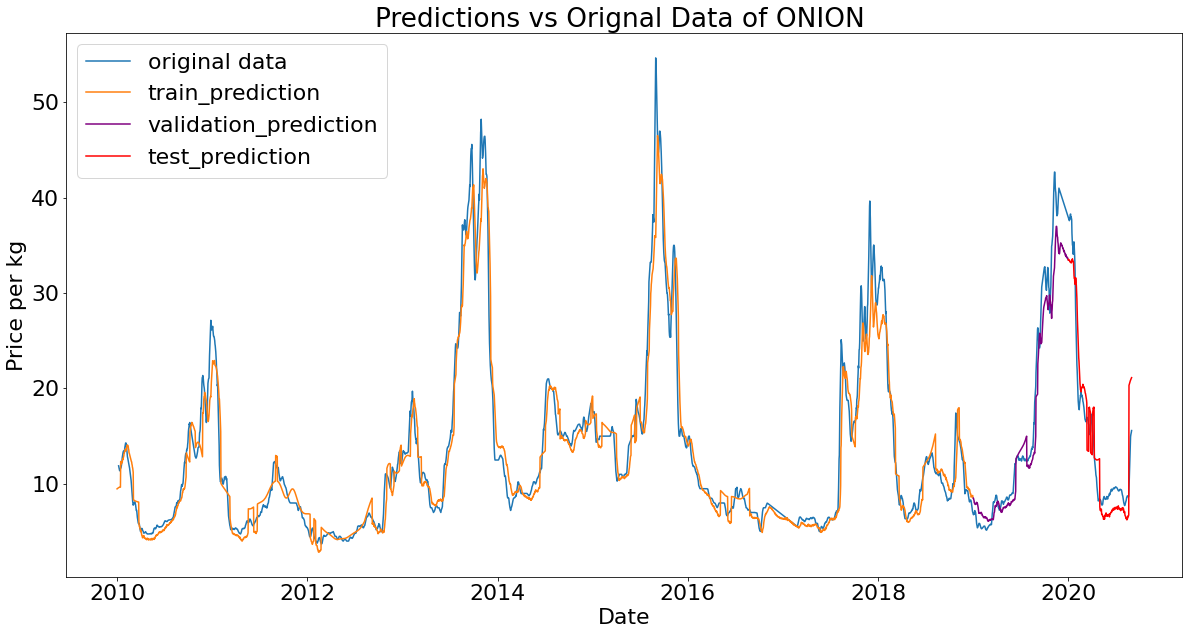

In [42]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(df['ds'], df['y']/100, label= "original data")
plt.plot(df['ds'][:-609], selected_forecast['yhat'][:-609]/100, label= "train_prediction")
plt.plot(selected_forecast['ds'][-609:-244], selected_forecast['yhat'][-609:-244]/100, color= 'purple', label= "validation_prediction")
plt.plot(selected_forecast['ds'][-244:], selected_forecast['yhat'][-244:]/100, color= 'red', label= "test_prediction")
plt.legend(loc="upper left")
plt.title("Predictions vs Orignal Data of ONION ")
plt.xlabel("Date")
plt.ylabel("Price per kg")
plt.show()

In [43]:
#prediction on model trained on 2010-2018 data
prediction_future = m.make_future_dataframe(periods=609)
final_forecast = m.predict(prediction_future)
final_forecast = validate(0.25,3, [0.1, 0.1, 0.6], [0.1, 0.1], final_forecast, df)


In [44]:
future_prediction_values = final_forecast['yhat'][-7:]

### ERROR analysis


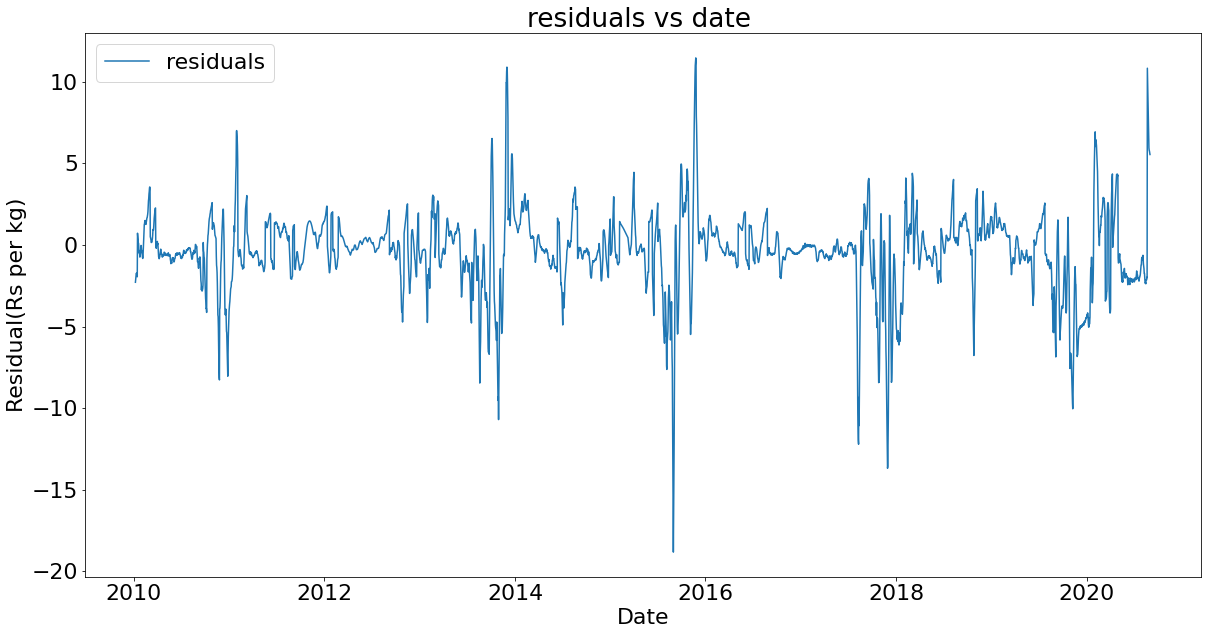

In [45]:
plt.figure(figsize=(20,10))
selected_forecast['error'] = selected_forecast['yhat'] - df['y']
plt.plot(selected_forecast['ds'], selected_forecast['error']/100, label= "residuals")
plt.legend(loc="upper left")
plt.title("residuals vs date ")
plt.xlabel("Date")
plt.ylabel("Residual(Rs per kg)")
plt.show()

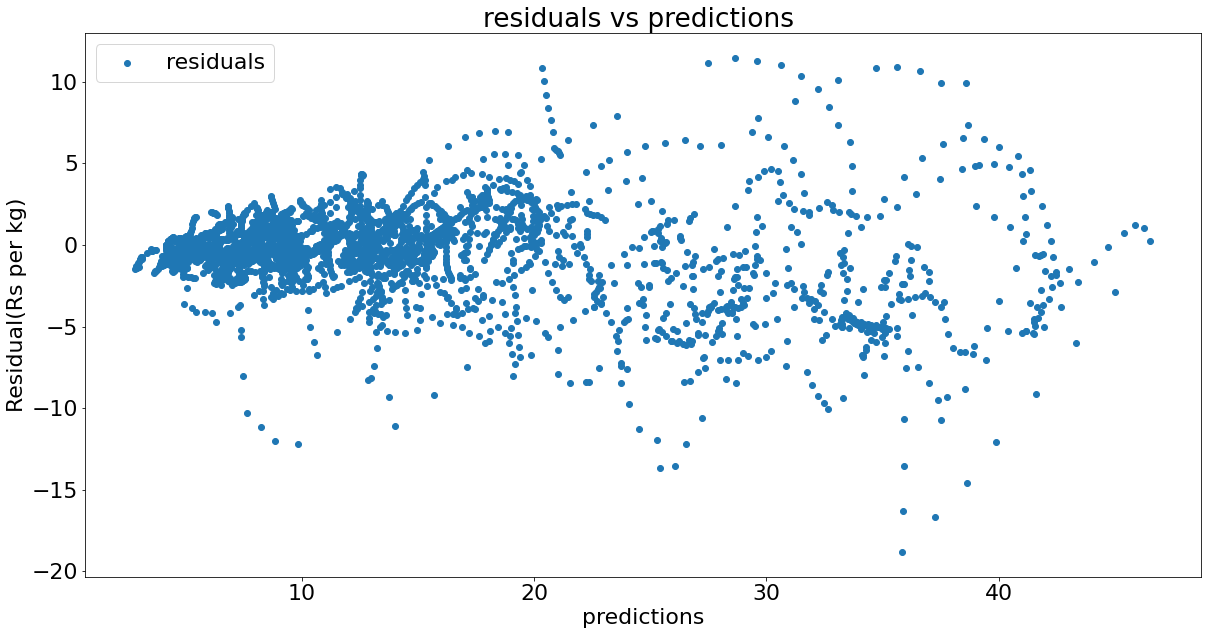

In [46]:
plt.figure(figsize=(20,10))
plt.scatter(selected_forecast['yhat']/100, selected_forecast['error']/100, label= "residuals")
plt.legend(loc="upper left")
plt.title("residuals vs predictions ")
plt.xlabel("predictions")
plt.ylabel("Residual(Rs per kg)")
plt.show()

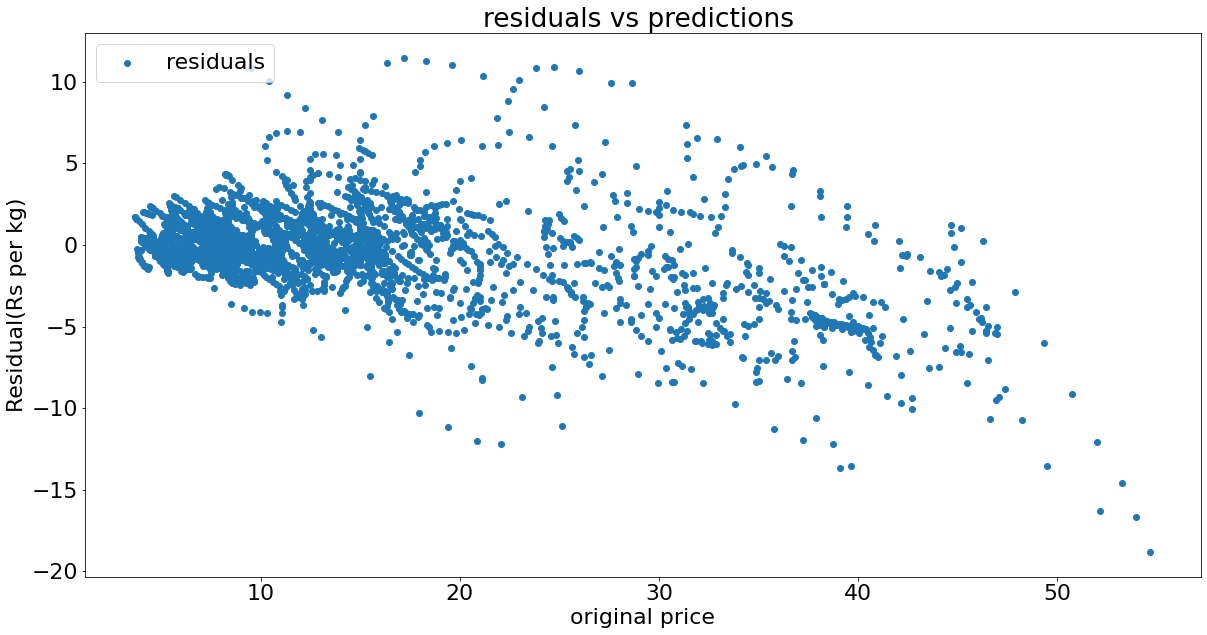

In [47]:
plt.figure(figsize=(20,10))
plt.scatter(df['y']/100, selected_forecast['error']/100, label= "residuals")
plt.legend(loc="upper left")
plt.title("residuals vs predictions ")
plt.xlabel("original price")
plt.ylabel("Residual(Rs per kg)")
plt.show()

- from the above graph we can see that there is curve like pattern
- this tells us that this model is performing poorly on higher price values as absoulute error is increasing.
- we can also see that for higher prices, the error is negative. That means the model is not able to rach the peaks(of prices) in data.

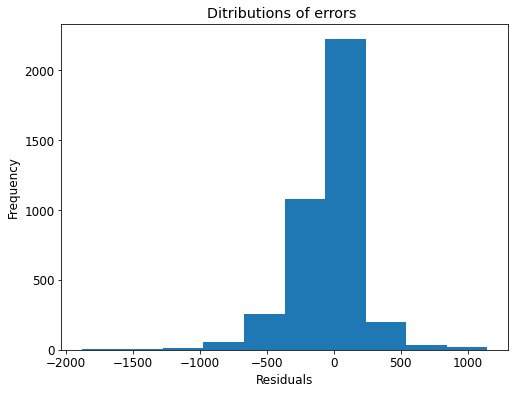

In [48]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,6))
plt.hist(selected_forecast['error'])
plt.title("Ditributions of errors ")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()